# Predict Stock Price

1. Get historic stock price data
2. Extract price to predict
3. Normalize
4. Create Time Series
5. Build model
6. Fit model
7. Test and evaluate

In [1]:
from keras import backend as K
import os
from importlib import reload

def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("cntk")

Using TensorFlow backend.
Using CNTK backend
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/keras/backend/cntk_backend.py:19: UserWarning: CNTK backend warning: GPU is not detected. CNTK's CPU version is not fully optimized,please run with GPU to get better performance.
  'CNTK backend warning: GPU is not detected. '


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
np.random.seed(7)

In [4]:
#load the dataset
msft_dataset = pd.read_csv('~/library/HistoricalQuotes.csv')
msft_dataset.head()

,date,close,volume,open,high,low
0,16:00,91.33,"67,998,445",86.82,91.475,85.2500
1,2018/02/05,88.00,50588980.0000,90.56,93.240,88.0000
2,2018/02/02,91.78,47484680.0000,93.64,93.970,91.5000
3,2018/02/01,94.26,46866010.0000,94.79,96.070,93.5813
4,2018/01/31,95.01,47448270.0000,93.75,95.400,93.5100


In [5]:
msft_dataset.dtypes

date       object
close     float64
volume     object
open      float64
high      float64
low       float64
dtype: object

In [6]:
msft_dataset['date'] = pd.to_datetime(msft_dataset['date'])
msft_dataset['close'] = pd.to_numeric(msft_dataset['close'], downcast='float')

In [7]:
msft_dataset.set_index('date',inplace=True)
msft_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2520 entries, 2018-02-07 16:00:00 to 2008-02-05 00:00:00
Data columns (total 5 columns):
close     2520 non-null float32
volume    2520 non-null object
open      2520 non-null float64
high      2520 non-null float64
low       2520 non-null float64
dtypes: float32(1), float64(3), object(1)
memory usage: 108.3+ KB


In [8]:
msft_dataset.sort_index(inplace=True)

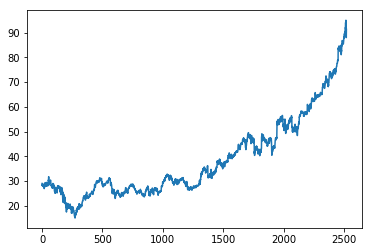

In [9]:
#extract just close prices as that is what we want to predict
msft_close = msft_dataset['close']
msft_close = msft_close.values.reshape(len(msft_close), 1)
plt.plot(msft_close)
plt.show()

In [10]:
#normalize data
scaler = MinMaxScaler(feature_range=(0,1))

In [11]:
msft_close = scaler.fit_transform(msft_close)
msft_close

array([[ 0.17430502],
       [ 0.167418  ],
       [ 0.16240922],
       ..., 
       [ 0.95955426],
       [ 0.91222137],
       [ 0.95391935]], dtype=float32)

In [12]:
#split data into train and test
train_size = int(len(msft_close)* 0.7)
test_size = len(msft_close) - train_size

msft_train, msft_test = msft_close[0:train_size, :], msft_close[train_size:len(msft_close), :]

print('Split data into train and test: ', len(msft_train), len(msft_test))

Split data into train and test:  1764 756


In [13]:
#need to now convert the data into time series looking back over a period of days...e.g. use last 7 days to predict price

def create_ts(ds, series):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

series = 7

trainX, trainY = create_ts(msft_train, series)
testX, testY = create_ts(msft_test, series)


In [14]:
trainX

array([[ 0.17430502,  0.167418  ,  0.16240922, ...,  0.16353619,
         0.16516405,  0.17292762],
       [ 0.167418  ,  0.16240922,  0.16791886, ...,  0.16516405,
         0.17292762,  0.16716754],
       [ 0.16240922,  0.16791886,  0.16353619, ...,  0.17292762,
         0.16716754,  0.1661658 ],
       ..., 
       [ 0.40045083,  0.40107691,  0.39894813, ...,  0.32607061,
         0.33633858,  0.31617832],
       [ 0.40107691,  0.39894813,  0.34447783, ...,  0.33633858,
         0.31617832,  0.32719761],
       [ 0.39894813,  0.34447783,  0.32607061, ...,  0.31617832,
         0.32719761,  0.33120459]], dtype=float32)

In [15]:
trainX[0]

array([ 0.17430502,  0.167418  ,  0.16240922,  0.16791886,  0.16353619,
        0.16516405,  0.17292762], dtype=float32)

In [16]:
#reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [19]:
#build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
#fit the model
model.fit(trainX, trainY, epochs=100, batch_size=32)

Epoch 1/100
1756/1756 [==============================] - 0s - loss: 0.0116     
Epoch 2/100
1756/1756 [==============================] - 0s - loss: 0.0026     
Epoch 3/100
1756/1756 [==============================] - 0s - loss: 0.0016     
Epoch 4/100
1756/1756 [==============================] - 0s - loss: 9.2738e-04     
Epoch 5/100
1756/1756 [==============================] - 0s - loss: 4.6664e-04     
Epoch 6/100
1756/1756 [==============================] - 0s - loss: 2.4888e-04     
Epoch 7/100
1756/1756 [==============================] - 0s - loss: 1.7485e-04     
Epoch 8/100
1756/1756 [==============================] - 0s - loss: 1.5534e-04     
Epoch 9/100
1756/1756 [==============================] - 0s - loss: 1.5097e-04     
Epoch 10/100
1756/1756 [==============================] - 0s - loss: 1.4955e-04     
Epoch 11/100
1756/1756 [==============================] - 0s - loss: 1.4849e-04     
Epoch 12/100
1756/1756 [==============================] - 0s - loss: 1.4429e-04     
E

1756/1756 [==============================] - 0s - loss: 8.1732e-05     
Epoch 98/100
1756/1756 [==============================] - 0s - loss: 8.1559e-05     
Epoch 99/100
1756/1756 [==============================] - 0s - loss: 8.0210e-05     
Epoch 100/100
1756/1756 [==============================] - 0s - loss: 7.9433e-05     


In [20]:
#test this model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)
#unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [21]:
#lets calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)



Train score: %.2f rmse 0.7209341979280773
Test score: %.2f rmse 4.938673008857972


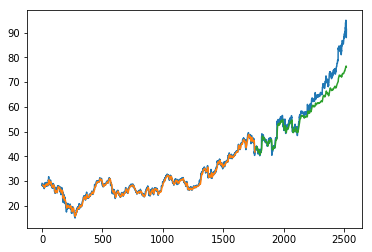

In [24]:
#lets plot the predictions on a graph and see how well it did
train_plot = np.empty_like(msft_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(msft_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(msft_close)-1, :] = testPredictions

#plot on graph
plt.plot(scaler.inverse_transform(msft_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()
